<a href="https://colab.research.google.com/github/bombaybrew/colab_experiments/blob/master/quickdraw_gpu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

REFERENCE:

https://colab.research.google.com/github/zaidalyafeai/zaidalyafeai.github.io/blob/master/sketcher/Sketcher.ipynb
https://github.com/googlecreativelab/quickdraw-dataset

In [ ]:
# !df -h

Filesystem      Size  Used Avail Use% Mounted on
overlay          69G   33G   33G  50% /
tmpfs            64M     0   64M   0% /dev
tmpfs           6.4G     0  6.4G   0% /sys/fs/cgroup
shm             5.8G     0  5.8G   0% /dev/shm
tmpfs           6.4G   16K  6.4G   1% /var/colab
/dev/sda1        75G   34G   42G  45% /opt/bin
tmpfs           6.4G     0  6.4G   0% /proc/acpi
tmpfs           6.4G     0  6.4G   0% /proc/scsi
tmpfs           6.4G     0  6.4G   0% /sys/firmware


In [21]:
# !free -mh

              total        used        free      shared  buff/cache   available
Mem:            12G        9.5G        187M        2.9M        3.0G         10G
Swap:            0B          0B          0B


In [68]:
# !nvidia-smi

Tue Jul 28 16:22:11 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P0    63W / 149W |  10868MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
# !mkdir data

In [83]:
import urllib.request
def download():
  
  base = 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/'
  classes = ['airplane','apple','ant','axe','banana','baseball','bee','beach','bird','book','bucket','bus','butterfly','cactus','cake','cannon','car','carrot','castle',
             'cat','chair','church','circle','clock','cloud','computer','cookie','cow','crab','crayon','cup','dolphin','donut','door','dragon','diamond','drums','duck',
             'ear','elephant','envelope','eraser','eye','face','fan','finger','fish','flower','frog','garden','grapes','grass','guitar','hammer','hand','hat','helmet',
             'horse','house','hospital','jail','kangaroo','knife','laptop','leg','lion','lollipop','map','microwave','monkey','moon','mountain','mouse','mug','nail',
             'nose','onion','owl','panda','parachute','parrot','passport','peanut','pencil','piano','pig','pizza','potato','rabbit','radio','rain','rainbow','river',
             'sandwich','saw','sun','shark','shoe','skull','snail','snowflake','spider','square','stairs','star','stove','strawberry','table','teapot','television','tent',
             'toilet','toothbrush','toothpaste','train','triangle','truck','umbrella','whale','zebra']
  for c in classes:
    cls_url = c.replace('_', '%20')
    path = base+cls_url+'.npy'
    print(path)
    urllib.request.urlretrieve(path, 'data/'+c+'.npy')

In [84]:
# download()

https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/stairs.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/star.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/stove.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/strawberry.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/table.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/teapot.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/television.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/tent.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/toilet.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/toothbrush.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/toothpaste.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/train.npy
https://storage.googleapis.com/quickdraw_dataset/full/n

In [7]:
# !ls -lah data

total 1.0G
drwxr-xr-x 2 root root 4.0K Jul 28 09:29 .
drwxr-xr-x 1 root root 4.0K Jul 28 09:29 ..
-rw-r--r-- 1 root root 109M Jul 28 09:29 apple.npy
-rw-r--r-- 1 root root  94M Jul 28 09:29 beach.npy
-rw-r--r-- 1 root root  90M Jul 28 09:29 book.npy
-rw-r--r-- 1 root root 125M Jul 28 09:29 bus.npy
-rw-r--r-- 1 root root  94M Jul 28 09:29 cake.npy
-rw-r--r-- 1 root root 137M Jul 28 09:29 car.npy
-rw-r--r-- 1 root root  91M Jul 28 09:29 clock.npy
-rw-r--r-- 1 root root  90M Jul 28 09:29 cloud.npy
-rw-r--r-- 1 root root  99M Jul 28 09:29 diamond.npy
-rw-r--r-- 1 root root 101M Jul 28 09:29 sun.npy


In [2]:
# IMPORTS

import os
import glob
import numpy as np
import pandas as pd
from tensorflow.keras import layers
from tensorflow import keras 
import tensorflow as tf
import matplotlib.pyplot as plt

In [71]:
# input_files = glob.iglob("data/*.npy")
# for f in input_files:
#   print(f)

In [3]:
def load_data(vfold_ratio=0.2, max_items_per_class= 5000):

  files = glob.iglob("data/*.npy")

  print('load_data','init variables', files)
  #initialize variables 
  x = np.empty([0, 784])
  y = np.empty([0])
  class_names = []

  #load each data file 
  for idx, file in enumerate(files):
    print('load_data','file - ', file)
    data = np.load(file)
    data = data[0: max_items_per_class, :]
    labels = np.full(data.shape[0], idx)

    x = np.concatenate((x, data), axis=0)
    y = np.append(y, labels)

    class_name, ext = os.path.splitext(os.path.basename(file))
    class_names.append(class_name)

  data = None
  labels = None

  print('load_data','randomizing dataset')
  #randomize the dataset 
  permutation = np.random.permutation(y.shape[0])
  x = x[permutation, :]
  y = y[permutation]

  print('load_data','generating test / train') 
  #separate into training and testing 
  vfold_size = int(x.shape[0]/100*(vfold_ratio*100))

  x_test = x[0:vfold_size, :]
  y_test = y[0:vfold_size]

  x_train = x[vfold_size:x.shape[0], :]
  y_train = y[vfold_size:y.shape[0]]
  return x_train, y_train, x_test, y_test, class_names

In [4]:
x_train, y_train, x_test, y_test, class_names = load_data(0.2, 3000)

load_data init variables <generator object _iglob at 0x7ffb8d77ce08>
load_data file -  data/horse.npy
load_data file -  data/rain.npy
load_data file -  data/pencil.npy
load_data file -  data/cannon.npy
load_data file -  data/jail.npy
load_data file -  data/lollipop.npy
load_data file -  data/crab.npy
load_data file -  data/square.npy
load_data file -  data/kangaroo.npy
load_data file -  data/stairs.npy
load_data file -  data/frog.npy
load_data file -  data/cloud.npy
load_data file -  data/fan.npy
load_data file -  data/nail.npy
load_data file -  data/bird.npy
load_data file -  data/toothbrush.npy
load_data file -  data/ant.npy
load_data file -  data/envelope.npy
load_data file -  data/face.npy
load_data file -  data/sandwich.npy
load_data file -  data/book.npy
load_data file -  data/parachute.npy
load_data file -  data/spider.npy
load_data file -  data/bus.npy
load_data file -  data/baseball.npy
load_data file -  data/flower.npy
load_data file -  data/toothpaste.npy
load_data file -  d

In [5]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
print("-----------")
print(x_train[0].shape)

(288000, 784)
(288000,)
(72000, 784)
(72000,)
-----------
(784,)


In [6]:
from random import randint
def visualise_random(x, y):

  idx = randint(0, len(x))
  plt.imshow(x[idx].reshape(28,28))
  print(class_names[int(y[idx])])

horse


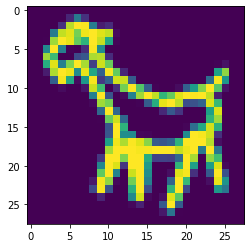

In [16]:
visualise_random(x_train, y_train)

In [7]:
len(class_names)

120

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


calc PCA.
[0.069055   0.04866982 0.04573589 0.02740687 0.02362293 0.02215663
 0.01923025 0.01844648 0.01727158 0.01504795]
calc TSNE.
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 6000 samples in 0.670s...
[t-SNE] Computed neighbors for 6000 samples in 50.367s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6000
[t-SNE] Computed conditional probabilities for sample 2000 / 6000
[t-SNE] Computed conditional probabilities for sample 3000 / 6000
[t-SNE] Computed conditional probabilities for sample 4000 / 6000
[t-SNE] Computed conditional probabilities for sample 5000 / 6000
[t-SNE] Computed conditional probabilities for sample 6000 / 6000
[t-SNE] Mean sigma: 556.740767
[t-SNE] KL divergence after 250 iterations with early exaggeration: 85.163132
[t-SNE] KL divergence after 300 iterations: 3.117031


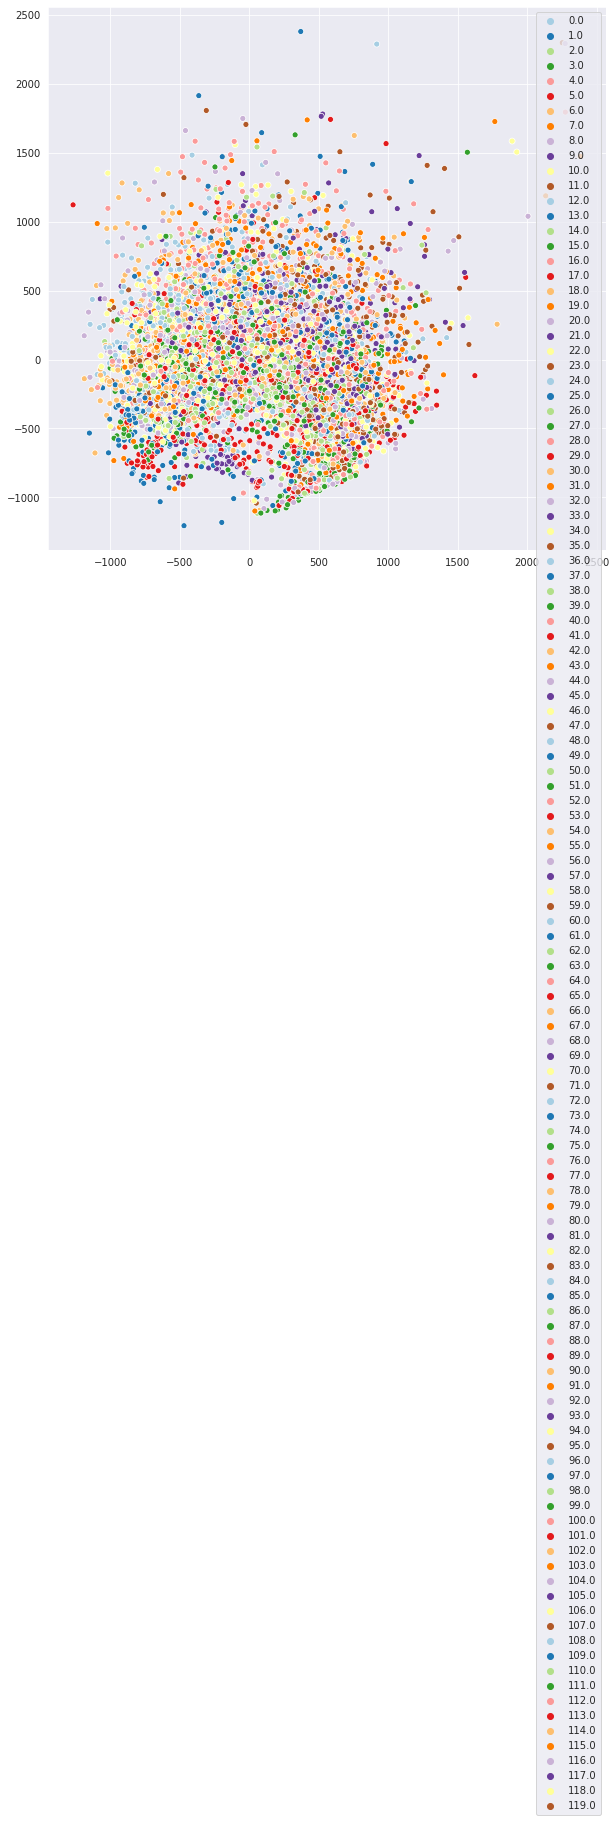

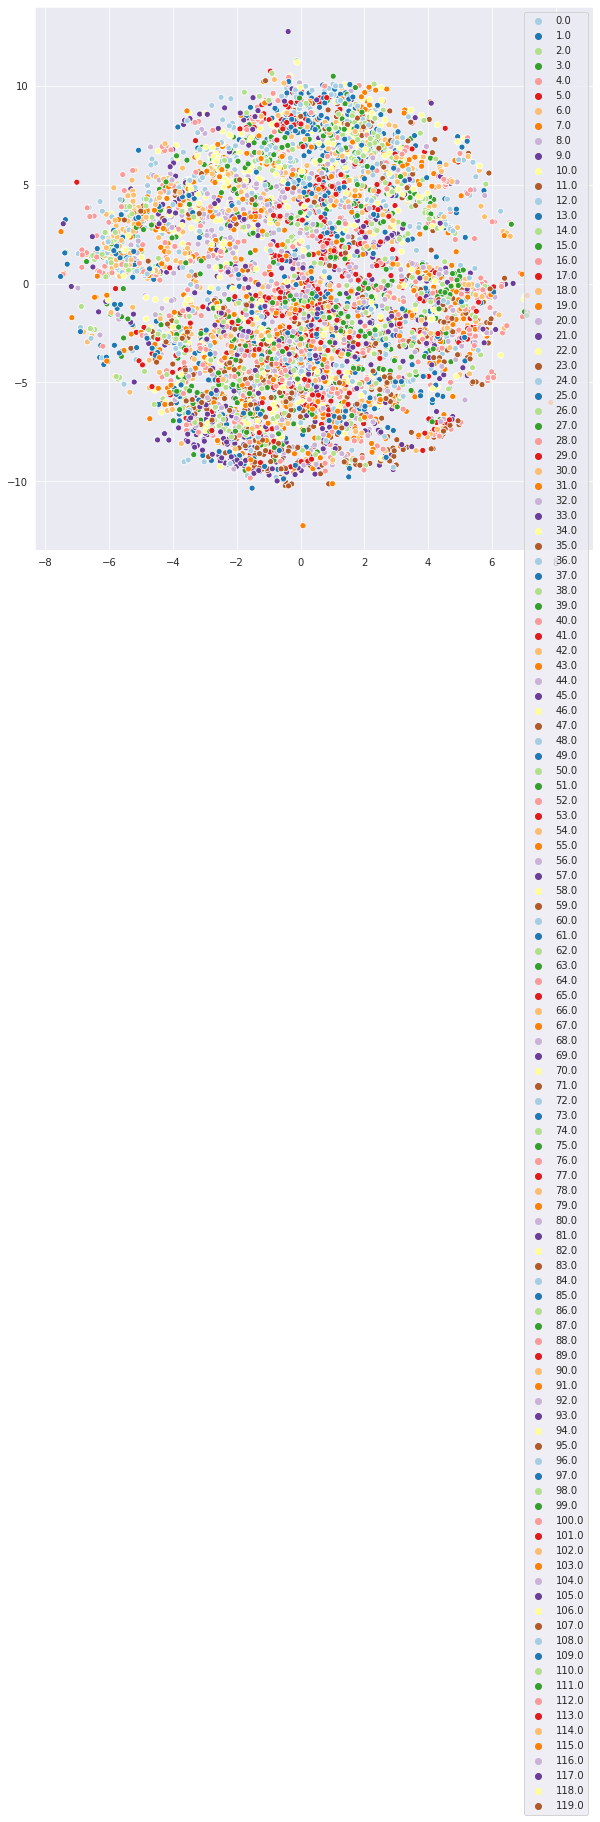

In [8]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
# from tsnecuda import TSNE

CONFIG_TOTAL_CLASSES = len(class_names)
CONFIG_DECOMPOSITION_SAMPLE_SIZE = 6000

import seaborn as sns
sns.set_style('darkgrid')
palette = sns.color_palette("Paired", CONFIG_TOTAL_CLASSES)
sns.set_palette(palette)

def plot_PCA(X, y):
  print('calc PCA.')
  pca = PCA(n_components=10)
  pca_result = pca.fit_transform(X)
  print(pca.explained_variance_ratio_)

  plt.figure(figsize=(10,10))
  ax = sns.scatterplot(pca_result[:,0], pca_result[:,1], hue=y, palette=palette)

  return pca_result

def plot_TSNE(X, y):
  print('calc TSNE.')
  tsne_projections = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300).fit_transform(X)
  plt.figure(figsize=(10,10))
  ax = sns.scatterplot(tsne_projections[:,0], tsne_projections[:,1], hue=y, palette=palette)

X = np.reshape(x_train, (x_train.shape[0], 28 * 28))[0:CONFIG_DECOMPOSITION_SAMPLE_SIZE]
y = y_train[0:CONFIG_DECOMPOSITION_SAMPLE_SIZE]

pca_result = plot_PCA(X, y)
plot_TSNE(X,y)

In [57]:
# !wget https://repo.continuum.io/miniconda/Miniconda3-4.5.4-Linux-x86_64.sh && bash Miniconda3-4.5.4-Linux-x86_64.sh -bfp /usr/local

In [58]:
# !conda install tsnecuda cuda101 -c cannylab

In [35]:
# import tsnecuda
# print(tsnecuda.test())

In [9]:
# Pre-Processing

image_size = 28

# Reshape and normalize
x_train = x_train.reshape(x_train.shape[0], image_size, image_size, 1).astype('float16')
x_test = x_test.reshape(x_test.shape[0], image_size, image_size, 1).astype('float16')

x_train /= 255.0
x_test /= 255.0

# Convert class vectors to class matrices
y_train = keras.utils.to_categorical(y_train, len(class_names))
y_test = keras.utils.to_categorical(y_test, len(class_names))

In [10]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
print("-----------")
print(x_train[0].shape)

(288000, 28, 28, 1)
(288000, 120)
(72000, 28, 28, 1)
(72000, 120)
-----------
(28, 28, 1)


In [11]:
x_train[0]

array([[[0.     ],
        [0.     ],
        [0.     ],
        [0.     ],
        [0.     ],
        [0.     ],
        [0.     ],
        [0.     ],
        [0.     ],
        [0.     ],
        [0.     ],
        [0.     ],
        [0.     ],
        [0.     ],
        [0.     ],
        [0.     ],
        [0.     ],
        [0.     ],
        [0.     ],
        [0.     ],
        [0.     ],
        [0.     ],
        [0.     ],
        [0.     ],
        [0.     ],
        [0.     ],
        [0.     ],
        [0.     ]],

       [[0.     ],
        [0.     ],
        [0.     ],
        [0.     ],
        [0.     ],
        [0.     ],
        [0.     ],
        [0.098  ],
        [0.4038 ],
        [0.1216 ],
        [0.     ],
        [0.     ],
        [0.     ],
        [0.03137],
        [0.01569],
        [0.     ],
        [0.     ],
        [0.     ],
        [0.     ],
        [0.     ],
        [0.     ],
        [0.     ],
        [0.     ],
        [0.     ],
        [0

In [60]:
import tensorflow as tf

# Define model
model = keras.Sequential()
model.add(layers.Convolution2D(16, (3, 3),padding='same', input_shape=x_train.shape[1:], activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Convolution2D(32, (3, 3), padding='same', activation= 'relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Convolution2D(64, (3, 3), padding='same', activation= 'relu'))
model.add(layers.MaxPooling2D(pool_size =(2,2)))
model.add(layers.Convolution2D(128, (3, 3), padding='same', activation= 'relu'))
model.add(layers.MaxPooling2D(pool_size =(2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='tanh'))
model.add(layers.Dense(128, activation='tanh'))
model.add(layers.Dense(len(class_names), activation='softmax')) 
# Train model
adam = tf.keras.optimizers.Adam()
model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])
print(model.summary())

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_43 (Conv2D)           (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_43 (MaxPooling (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_44 (MaxPooling (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 3, 3, 64)          0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 3, 3, 128)       

In [23]:
model.fit(x = x_train, y = y_train, validation_split=0.1, batch_size = 256, epochs=10)

Epoch 1/5
1688/1688 [==============================] - 35s 21ms/step - loss: 1.7959 - accuracy: 0.5678 - val_loss: 1.2767 - val_accuracy: 0.6788
Epoch 2/5
1688/1688 [==============================] - 35s 21ms/step - loss: 1.1461 - accuracy: 0.7114 - val_loss: 1.0895 - val_accuracy: 0.7244
Epoch 3/5
1688/1688 [==============================] - 34s 20ms/step - loss: 0.9917 - accuracy: 0.7467 - val_loss: 0.9936 - val_accuracy: 0.7470
Epoch 4/5
1688/1688 [==============================] - 35s 20ms/step - loss: 0.9006 - accuracy: 0.7684 - val_loss: 0.9509 - val_accuracy: 0.7575
Epoch 5/5
1688/1688 [==============================] - 34s 20ms/step - loss: 0.8373 - accuracy: 0.7829 - val_loss: 0.9273 - val_accuracy: 0.7630


In [24]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test accuarcy: {:0.2f}%'.format(score[1] * 100))

Test accuarcy: 75.97%


In [26]:
model.fit(x = x_train, y = y_train, validation_split=0.1, batch_size = 256, epochs=5)

Epoch 1/5
1688/1688 [==============================] - 39s 23ms/step - loss: 1.9298 - accuracy: 0.5311 - val_loss: 1.3394 - val_accuracy: 0.6615
Epoch 2/5
1688/1688 [==============================] - 39s 23ms/step - loss: 1.1985 - accuracy: 0.6945 - val_loss: 1.1295 - val_accuracy: 0.7101
Epoch 3/5
1688/1688 [==============================] - 49s 29ms/step - loss: 1.0348 - accuracy: 0.7341 - val_loss: 1.0382 - val_accuracy: 0.7301
Epoch 4/5
1688/1688 [==============================] - 48s 29ms/step - loss: 0.9386 - accuracy: 0.7567 - val_loss: 0.9821 - val_accuracy: 0.7460
Epoch 5/5
1688/1688 [==============================] - 39s 23ms/step - loss: 0.8743 - accuracy: 0.7719 - val_loss: 0.9506 - val_accuracy: 0.7540


In [29]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test accuarcy: {:0.2f}%'.format(score[1] * 100))

Test accuarcy: 0.93%


In [58]:
print('1.1.2')
model.fit(x = x_train, y = y_train, validation_split=0.1, batch_size = 256, epochs=12)

1.1.2
Epoch 1/12
1688/1688 [==============================] - 19s 11ms/step - loss: 1.7977 - accuracy: 0.5496 - val_loss: 1.6182 - val_accuracy: 0.5876
Epoch 2/12
1688/1688 [==============================] - 19s 11ms/step - loss: 1.4771 - accuracy: 0.6245 - val_loss: 1.4324 - val_accuracy: 0.6349
Epoch 3/12
1688/1688 [==============================] - 19s 11ms/step - loss: 1.3416 - accuracy: 0.6566 - val_loss: 1.3238 - val_accuracy: 0.6627
Epoch 4/12
1688/1688 [==============================] - 18s 11ms/step - loss: 1.2586 - accuracy: 0.6760 - val_loss: 1.2550 - val_accuracy: 0.6780
Epoch 5/12
1688/1688 [==============================] - 18s 11ms/step - loss: 1.1994 - accuracy: 0.6905 - val_loss: 1.2356 - val_accuracy: 0.6810
Epoch 6/12
1688/1688 [==============================] - 18s 11ms/step - loss: 1.1538 - accuracy: 0.7017 - val_loss: 1.1835 - val_accuracy: 0.6982
Epoch 7/12
1688/1688 [==============================] - 18s 11ms/step - loss: 1.1175 - accuracy: 0.7103 - val_loss: 1.

In [59]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test accuarcy: {:0.2f}%'.format(score[1] * 100))

Test accuarcy: 71.74%


In [61]:
print('1.1.3')
model.fit(x = x_train, y = y_train, validation_split=0.1, batch_size = 256, epochs=12)

1.1.3
Epoch 1/12
1688/1688 [==============================] - 24s 14ms/step - loss: 2.1052 - accuracy: 0.4870 - val_loss: 1.5284 - val_accuracy: 0.6115
Epoch 2/12
1688/1688 [==============================] - 24s 14ms/step - loss: 1.3524 - accuracy: 0.6559 - val_loss: 1.2658 - val_accuracy: 0.6783
Epoch 3/12
1688/1688 [==============================] - 24s 15ms/step - loss: 1.1808 - accuracy: 0.6966 - val_loss: 1.1571 - val_accuracy: 0.7017
Epoch 4/12
1688/1688 [==============================] - 24s 14ms/step - loss: 1.0855 - accuracy: 0.7190 - val_loss: 1.1197 - val_accuracy: 0.7110
Epoch 5/12
1688/1688 [==============================] - 24s 14ms/step - loss: 1.0209 - accuracy: 0.7344 - val_loss: 1.0711 - val_accuracy: 0.7210
Epoch 6/12
1688/1688 [==============================] - 24s 14ms/step - loss: 0.9730 - accuracy: 0.7461 - val_loss: 1.0548 - val_accuracy: 0.7283
Epoch 7/12
1688/1688 [==============================] - 24s 14ms/step - loss: 0.9365 - accuracy: 0.7550 - val_loss: 1.

In [62]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test accuarcy: {:0.2f}%'.format(score[1] * 100))

Test accuarcy: 74.62%


In [64]:
model.save('qd_cnn_74.62.h5')

In [66]:
!ls -lah

total 58M
drwxr-xr-x 1 root root 4.0K Jul 28 15:27 .
drwxr-xr-x 1 root root 4.0K Jul 28 08:56 ..
drwxr-xr-x 1 root root 4.0K Jul 22 16:16 .config
drwxr-xr-x 2 root root 4.0K Jul 28 12:07 data
-rw-r--r-- 1 root root  56M Jun  7  2018 Miniconda3-4.5.4-Linux-x86_64.sh
-rw-r--r-- 1 root root 2.2M Jul 28 15:27 qd_cnn_74.62.h5
drwxr-xr-x 1 root root 4.0K Jul 10 16:29 sample_data


In [67]:
from google.colab import files
files.download('qd_cnn_74.62.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>